In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
import pickle

In [2]:
with open('Image_Data_256x256.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
data.shape[0]

4000

In [4]:
bbox_folder = 'archive/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))
len(bb_paths)

4000

In [6]:
path = "archive/Images - 1/Images - 1/"
image_paths = glob(os.path.join(path,'*.jpg'))

bbox_folder = 'archive/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))


Image_data = []
Label_data = []
Image_path = []

for i in bb_paths:
    if os.path.exists(i):
        if os.path.getsize(i) == 0:
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(data[bb_paths.index(i)])
            Label_data.append('0')
        else:
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(data[bb_paths.index(i)])
            Label_data.append('1')

In [7]:
df = pd.DataFrame({'Image_path': Image_path, 'Image': Image_data, 'Label': Label_data})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_path  4000 non-null   object
 1   Image       4000 non-null   object
 2   Label       4000 non-null   object
dtypes: object(3)
memory usage: 93.9+ KB


In [9]:
np.unique(df.Label, return_counts=True)

(array(['0', '1'], dtype=object), array([ 388, 3612]))

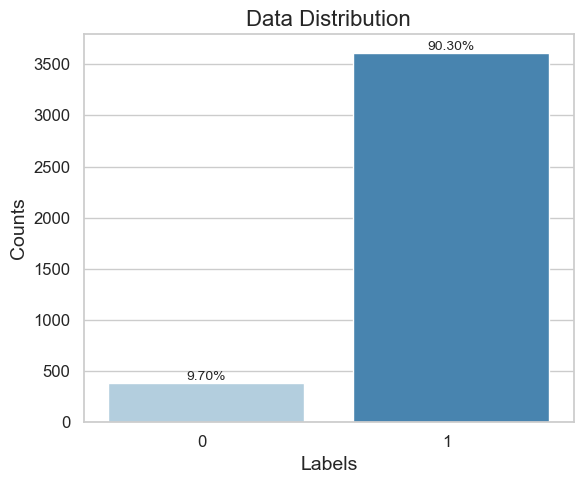

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels, counts = np.unique(df.Label, return_counts=True)
total_samples = len(df.Label)
percentages = (counts / total_samples) * 100

data = pd.DataFrame({'Labels': labels, 'Counts': counts, 'Percentages': percentages})

sns.set(style="whitegrid")
plt.figure(figsize=(6, 5))
ax = sns.barplot(x='Labels', y='Counts', data=data, palette="Blues")

for i, p in enumerate(ax.patches):
    percentage = f'{percentages[i]:.2f}%'
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), percentage, ha='center', va='bottom', fontsize=10)

plt.title('Data Distribution', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Features = np.stack(df['Image'].values)
Target = np.stack(df['Label'].values)
x_train, x_test, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.2,random_state=666)
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [21]:
x_train = x_train.reshape(x_train.shape[0], *(256, 256, 3))
x_test = x_test.reshape(x_test.shape[0], *(256, 256, 3))

## VGG19 Model

In [22]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Flatten, Dense, BatchNormalization

input_shape = (256, 256, 3)

vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg19_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19_model)
model.add(Flatten())

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [41]:
features = model.predict(x_train)
x_test_features = model.predict(x_test)

25/25 [==============================] - 86s 3s/step


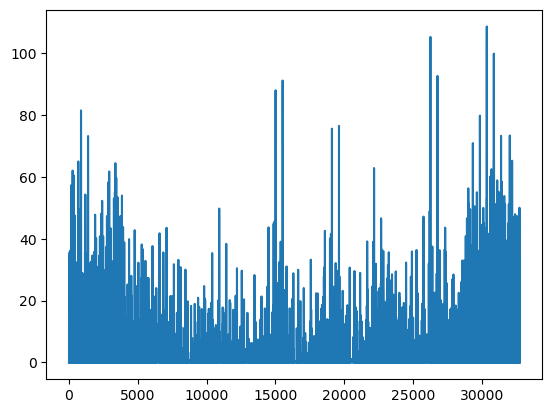

In [42]:
features = features.reshape((features.shape[0], -1))
x_test_features = x_test_features.reshape((x_test_features.shape[0], -1))
plt.plot(features[311])

## KNN with VGG19 Features

0.84875
0.8376061763862356


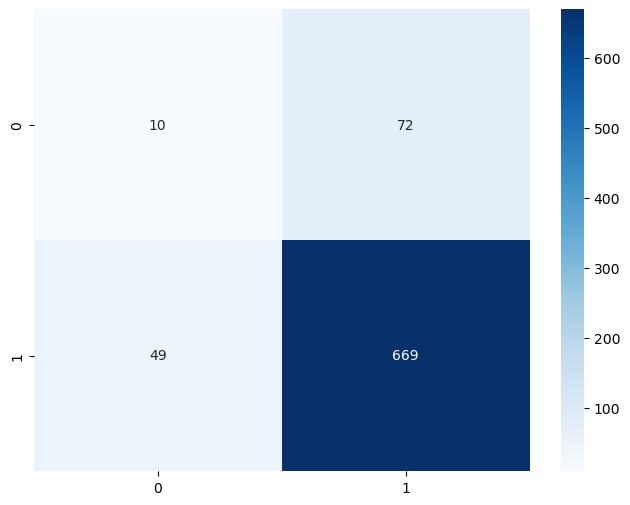

In [125]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(features, y_train)
y_pred = knn_model.predict(x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## PCA - No use

In [18]:
# from sklearn.decomposition import PCA

# n_components = 1000

# pca = PCA(n_components=n_components)
# features_pca = pca.fit_transform(features)
# x_test_features_pca = pca.fit_transform(x_test_features)

In [19]:
# knn_model = KNeighborsClassifier(n_neighbors=1) 
# knn_model.fit(features_pca, y_train)
# y_pred = knn_model.predict(x_test_features_pca)
# print(accuracy_score(y_test, y_pred))
# print(f1_score(y_test,y_pred,average="weighted"))

In [20]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.show()

## Kernal PCA

In [1]:
# No use

## Lasso Feature Selection

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_sc = scaler.fit_transform(features)
x_test_features_sc = scaler.transform(x_test_features)

In [107]:
from sklearn.linear_model import Lasso

alpha = 0.01 ## Increasing makes more features sparse
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(features, y_train)
klp = lasso_model.predict(x_test_features)

In [108]:
Lasso_features = []
for i in features:
    Lasso_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_features = np.array(Lasso_features)

Lasso_x_test_features = []
for i in x_test_features:
    Lasso_x_test_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_x_test_features = np.array(Lasso_x_test_features)

In [109]:
print(f'{len(features[0])},{len(Lasso_features[0])}')

32768,1932


0.845
0.8292352018895971


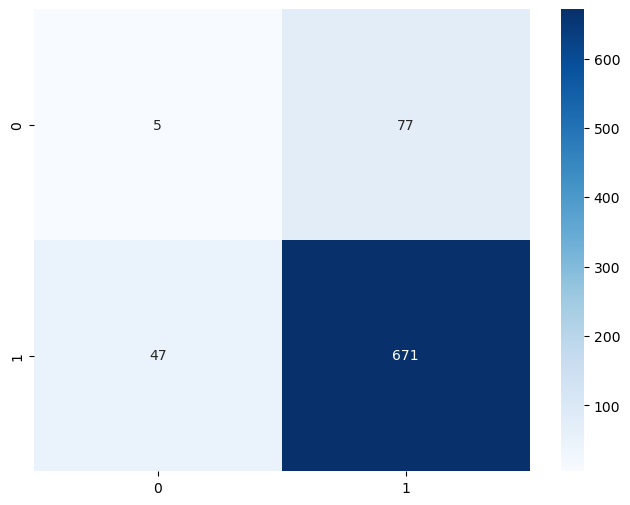

In [128]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(Lasso_features, y_train)
y_pred = knn_model.predict(Lasso_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## ElasticNet Features

In [130]:
from sklearn.linear_model import ElasticNet
alpha = 0.01
l1_ratio = 0.5

elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elastic_net_model.fit(features, y_train)

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e-01, tolerance: 2.767e-02
  model = cd_fast.enet_coordinate_descent(
/Users/harishneelam/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e-01, tolerance: 2.767e-02
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.01)

In [131]:
EN_features = []
for i in features:
    EN_features.append(np.array(i[elastic_net_model.coef_[0] != 0]))
EN_features = np.array(EN_features)

EN_x_test_features = []
for i in x_test_features:
    EN_x_test_features.append(np.array(i[elastic_net_model.coef_[0] != 0]))
EN_x_test_features = np.array(EN_x_test_features)

0.85125
0.8354861335342446


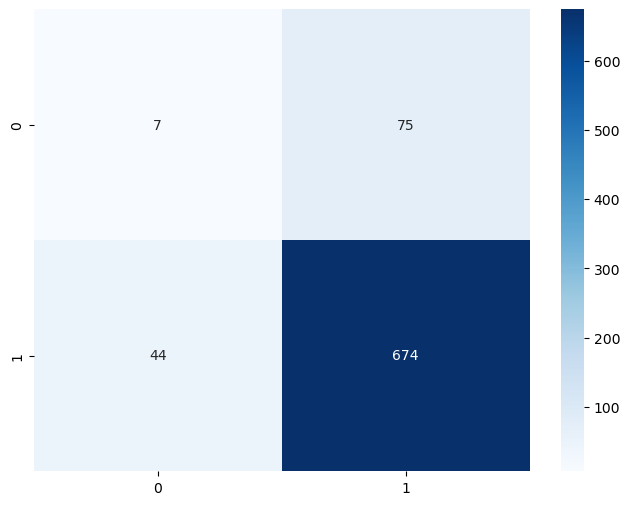

In [134]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(EN_features, y_train)
y_pred = knn_model.predict(EN_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## Convex Optimization - Proximal Gradient method

In [189]:
from scipy.optimize import minimize

def objective_function(x, A, b, lambd):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + lambd * np.linalg.norm(x, 1)

def proximal_gradient_descent_scipy(A, b, lambd, x0, max_iter=10, tol=1e-4):
    result = minimize(
        fun=objective_function,
        x0=x0,
        args=(A, b, lambd),
        method='L-BFGS-B',  
        options={'maxiter': max_iter, 'disp': True}
    )

    return result.x

A = np.matrix(Lasso_features)
b = np.matrix(np.argmax(y_train, axis=1))

resulting_coefficients = proximal_gradient_descent_scipy(A, b, lambd=0.05, x0=np.zeros(A.shape[1]))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1932     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44700D+03    |proj g|=  1.88112D+05


 This problem is unconstrained.



At iterate    1    f=  1.59124D+02    |proj g|=  2.73429D+03

At iterate    2    f=  1.51856D+02    |proj g|=  1.85325D+03

At iterate    3    f=  1.34369D+02    |proj g|=  1.29386D+03

At iterate    4    f=  1.27708D+02    |proj g|=  2.30517D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1932      4      8      1     0     0   2.305D+03   1.277D+02
  F =   127.70795357364629     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


In [190]:
rc = np.round(resulting_coefficients,4)
sum(rc!=0)

1203

In [191]:
PGD_features = []
for i in Lasso_features:
    PGD_features.append(np.array(i[rc != 0]))
PGD_features = np.array(PGD_features)

PGD_x_test_features = []
for i in Lasso_x_test_features:
    PGD_x_test_features.append(np.array(i[rc != 0]))
PGD_x_test_features = np.array(PGD_x_test_features)

0.82875
0.8210151989602172


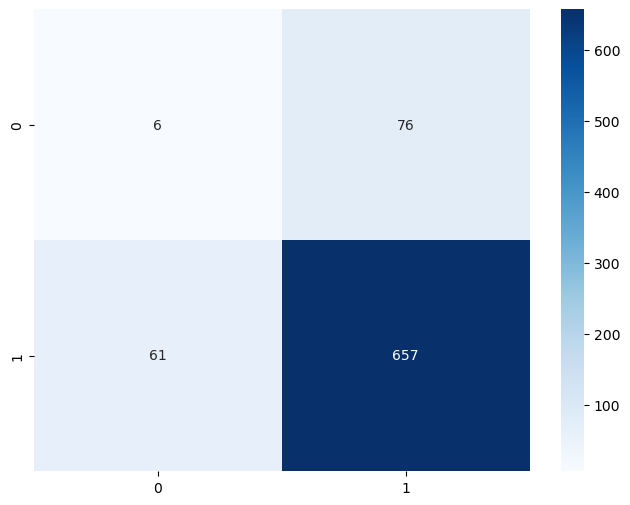

In [192]:
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(PGD_features, y_train)
y_pred = knn_model.predict(PGD_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## Anomaly Detection

In [198]:
from sklearn import svm

svc = svm.OneClassSVM(nu=0.01, kernel='rbf', gamma=0.1)

svc.fit(Lasso_features)
test_predictions = svc.predict(Lasso_x_test_features)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.82875
0.8210151989602172


In [199]:
np.unique(test_predictions,return_counts=True)

(array([-1]), array([800]))